In [2]:
%reset -f
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
import datetime
import re
from IPython.display import clear_output

# import classes
import Coviddataclass as cd

# fontsizes for plots
BIG_TEXT   = 18
MED_TEXT   = 14
SMALL_TEXT = 10

In [3]:
# load and clean data
df  = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')
df2 = pd.read_csv('state_policy_updates_20201114_0719.csv')
data_manager = cd.Coviddataclass()

df, df2 = data_manager.clean_data(df, df2)

C:\Users\alexc\Documents\GitHub\covid-19-data-analysis\Coviddataclass.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_cases_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')] =\
C:\Users\alexc\Documents\GitHub\covid-19-data-analysis\Coviddataclass.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_deaths_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')] =\


Correlate COVID-19 responses at the state and local level with the number of new cases and deaths at a variable time (14 days by default). This will use the 7 day average at the date in question to avoid outliers.

In [8]:
def calculate_deltas(measure_period=14, filtered_policies=None, case_df=df, policy_df=df2):
    """For every policy implementation at the state and county level, calculate the change in case and death numbers. 
    inputs: 
    measure_period    -- time to wait
    min_samples       -- minimum number of samples
    filtered_policies -- selected policies to select
    
    returns: 
    A copy of the df (covid policies) dataframe with 2 appended columns for the change in case and death numbers. 
    """
    
    # initialize wait period before measurement
    wait_period = datetime.timedelta(days=measure_period) # time in days to watch change in case / death number
    day_1 = datetime.timedelta(days=1)
    
    # filter policies if needed and make a 2 copies of the original policies dataframe- one for iteration and another 
    # for modification
    
    if filtered_policies is not None: 
        all_policies  = policy_df.loc[policy_df['policy_type'].isin(filtered_policies)]
        policy_deltas = policy_df.loc[policy_df['policy_type'].isin(filtered_policies)]
    else: 
        all_policies  = policy_df.copy()
        policy_deltas = policy_df.copy()
    
    # initially fill the delta column with nan
    policy_deltas.loc[:, f"case_{measure_period}_day_delta"] = np.nan
    policy_deltas.loc[:, f"case_{measure_period}_day_accel"] = np.nan
    policy_deltas.loc[:, f"death_{measure_period}_day_delta"] = np.nan
    policy_deltas.loc[:, f"death_{measure_period}_day_accel"] = np.nan
    
    i=0 # counter to time the loop
    state_cases_dict = dict()

    # load all state-aggregated datasets into a dictionary
    print("aggregating state data")
    for state in policy_df['state_id'].unique(): 
        state_cases_dict[state]=data_manager.get_cases(df=case_df, level="state", state=state)
    
    print("aggregating state data complete")
        
    # loop through all policies in the policy dataset
    for index, data in all_policies.iterrows(): 

        # handle state info
        if data.policy_level == "state": 
            policy_case_df = state_cases_dict[data.state_id]

        # handle county info
        else: 
            policy_case_df = data_manager.get_cases(df=case_df, level="county", county=data.county, state=data.state_id)

        # output status updates since this loop takes a long time (~3 minutes)
        i += 1
        if i%100 == 0: 
            print(f"record {i}/{len(all_policies.index)}")
        policy_date = pd.to_datetime(data['date'])
        measure_date = policy_date + wait_period
        
        # pass if the measure date is within 3 days (gives the case data time to update)
        if measure_date > pd.Timestamp.today() - datetime.timedelta(days=3): 
            continue
        
        # calculate "velocity" of covid cases
        cases_start  = policy_case_df[policy_case_df.index==policy_date ]['new_cases_7day_1e6' ].values
        cases_end    = policy_case_df[policy_case_df.index==measure_date]['new_cases_7day_1e6' ].values
        deaths_start = policy_case_df[policy_case_df.index==policy_date ]['new_deaths_7day_1e6'].values
        deaths_end   = policy_case_df[policy_case_df.index==measure_date]['new_deaths_7day_1e6'].values

        delta_cases  = cases_end  - cases_start
        delta_deaths = deaths_end - deaths_start
        
        policy_deltas.at[index, f"case_{measure_period}_day_delta"]  = delta_cases
        policy_deltas.at[index, f"death_{measure_period}_day_delta"] = delta_deaths
        
        # calculate "acceleration" of covid cases
        # (velocity at end of measure period - velocity at start) / measure period 
        c11 = policy_case_df[policy_case_df.index==measure_date       ]['new_cases_7day_1e6' ].values
        c12 = policy_case_df[policy_case_df.index==measure_date+day_1 ]['new_cases_7day_1e6' ].values
        
        c21 = policy_case_df[policy_case_df.index==policy_date        ]['new_cases_7day_1e6' ].values
        c22 = policy_case_df[policy_case_df.index==policy_date+day_1  ]['new_cases_7day_1e6' ].values
        
        d11 = policy_case_df[policy_case_df.index==measure_date       ]['new_deaths_7day_1e6'].values
        d12 = policy_case_df[policy_case_df.index==measure_date+day_1 ]['new_deaths_7day_1e6'].values
        
        d21 = policy_case_df[policy_case_df.index==policy_date        ]['new_deaths_7day_1e6'].values
        d22 = policy_case_df[policy_case_df.index==policy_date+day_1  ]['new_deaths_7day_1e6'].values
        
        case_accel   = ((c12-c11) - (c21-c22)) / measure_period
        deaths_accel = ((d12-d11) - (d21-d22)) / measure_period
        
        policy_deltas.at[index, f"case_{measure_period}_day_accel"]  = case_accel
        policy_deltas.at[index, f"death_{measure_period}_day_accel"] = deaths_accel
        
    return policy_deltas

In [9]:
policy_deltas = calculate_deltas()

aggregating state data
aggregating state data complete
record 100/3415
record 200/3415
record 300/3415
record 400/3415
record 500/3415
record 600/3415
record 700/3415
record 800/3415
record 900/3415
record 1000/3415
record 1100/3415
record 1200/3415
record 1300/3415
record 1400/3415
record 1500/3415
record 1600/3415
record 1700/3415
record 1800/3415
record 1900/3415
record 2000/3415
record 2100/3415
record 2200/3415
record 2300/3415
record 2400/3415
record 2500/3415
record 2600/3415
record 2700/3415
record 2800/3415
record 2900/3415
record 3000/3415
record 3100/3415
record 3200/3415
record 3300/3415
record 3400/3415


In [11]:
policy_deltas.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases,case_14_day_delta,case_14_day_accel,death_14_day_delta,death_14_day_accel
0,New York,bronx,36005.0,county,2020-06-08,Non-Essential Businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...,0,-2.443889,-0.024838,-0.457621,0.000745
1,Delaware,statewide,NaN,state,2020-03-27,Modify Medicaid Requirements,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,0,11.178574,0.054766,0.046340,0.022568
2,Florida,statewide,NaN,state,2020-03-18,Expand Medicaid Telehealth Coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,0,3.450263,0.073745,0.040246,0.002667
3,Michigan,delta,26041.0,county,2020-07-31,Entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...,0,2.348715,0.112501,0.000000,0.000000
4,Nebraska,box butte,31013.0,county,2020-03-30,Shelter in Place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual,0,1.262512,0.000000,0.000000,0.000000


In [12]:
def delta_stats(deltas, measure_period=14, min_samples=10):
    """Take the deltas calculated with each policy and calculate the average and sd. 
    inputs: 
    deltas         -- dataframe of policy deltas on which to do the calculations
    measure_period -- how long to wait before measuring the effect of the policy
    min_samples    -- minimum number of samples that a policy must have for reporting of average and std
    
    returns: 
    A dataframe with a record for the start/stop of each policy type and the average / std of the change in 
    case / death numbers measure_period days after implementation
    """

    # generate a new list of policy types differentiating between start and stop 
    
    policy_types = ([elem+" - start" for elem in deltas['policy_type'].unique()] + 
                    [elem+" - stop"  for elem in deltas['policy_type'].unique()])
    
    case_avg, death_avg, case_std, death_std, num_samples = [], [], [], [], []
    case_accel_avg, death_accel_avg, case_accel_std, death_accel_std = [], [], [], []
    
    for policy in policy_types:
        if policy.endswith("stop"):
            len_index = -7
            start_stop = "stop"
        else: 
            len_index = -8
            start_stop = "start"
            
        case_data  = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'case_{measure_period}_day_delta']

        death_data = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'death_{measure_period}_day_delta']

        case_accel_data = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'case_{measure_period}_day_accel']
        
        death_accel_data = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'death_{measure_period}_day_accel']

        num_samples.append(len(case_data))

        case_avg.append(np.nanmean(case_data.to_numpy()))
        death_avg.append(np.nanmean(death_data.to_numpy()))
            
        case_std.append(np.nanstd(case_data.to_numpy()))
        death_std.append(np.nanstd(death_data.to_numpy()))
        
        case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
        death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))
        
        case_accel_std.append(np.nanstd(case_accel_data.to_numpy()))
        death_accel_std.append(np.nanstd(death_accel_data.to_numpy()))
        
        
        
    # construct the dataframe to tabulate the data
    delta_stats = pd.DataFrame(np.transpose([case_avg, case_accel_avg, death_avg, death_accel_avg, 
                                             case_std, case_accel_std, death_std, death_accel_std, 
                                             num_samples]), index = policy_types, 
                               columns=['case_avg', 'case_accel_avg', 'death_avg', 'death_accel_avg', 
                                        'case_std', 'case_accel_std', 'death_std', 'death_accel_std', 
                                        'num_samples']
                              )

    # drop record with less than 10 samples
    delta_stats.drop(delta_stats[delta_stats['num_samples']<=min_samples].index, inplace=True)
    return delta_stats

In [13]:
deltas = delta_stats(deltas=policy_deltas)
deltas.head()

<ipython-input-12-dd3eb1eee9a0>:43: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-12-dd3eb1eee9a0>:44: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-12-dd3eb1eee9a0>:49: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-12-dd3eb1eee9a0>:50: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


,case_avg,case_accel_avg,death_avg,death_accel_avg,case_std,case_accel_std,death_std,death_accel_std,num_samples
Non-Essential Businesses - start,3.410356,0.101920,-0.032258,-0.000730,13.893829,0.641354,0.521567,0.023432,139.0
Modify Medicaid Requirements - start,4.822431,0.038011,0.261388,0.002146,7.729249,0.078920,0.556785,0.004519,51.0
Expand Medicaid Telehealth Coverage - start,3.220227,0.031105,0.115040,0.001223,4.079065,0.063633,0.197877,0.003508,50.0
Entertainment - start,3.252256,-0.005115,-0.008554,-0.001373,11.742315,0.242292,0.554611,0.025760,123.0
Shelter in Place - start,3.013021,0.026624,0.105258,0.001414,8.252146,0.180978,0.287886,0.006156,456.0


The "Mean of empty slice" warnings may be safely ignored- these correspond to policies for no counties / states have implemented (e.g. stopping policies related to "allow audio only telehealth")

## Connecting the start/stop of a policy and case/death numbers

Let's explore how these numbers look by examining what is associated with the most extreme changes in each of the 4 metrics (i.e. largest increase / decrease in the average / acceleration of new cases / deaths). 

What should we expect? 

During the beginning of the first wave, state and local governemnts issued a flurry of ordinances aimed at slowing down the spread of the pandemic. Since many policies were started before the peak of the first wave, it's likely that we'll see the start of many policies correlated with an increase in average number of new cases coupled with a decrease in the acceleration of new cases. 

Policies are typically stopped when cases are declining, so we might expect that stopping a policy might be correlated with a decrease in the average number of cases. However, stopping a policy may also cause more spreading, especially if people aren't following basic guidelines. This means that stopping a policy might be correlated with an increase in the acceleration of new cases. 

Deaths are a little harder to judge. These datapoints for increase in average and acceleration were taken for a 2 week period. Since death numbers typically lag case numbers, it's ambiguous as to how much correlation between the start/stop of a policy would appear in this dataset. 

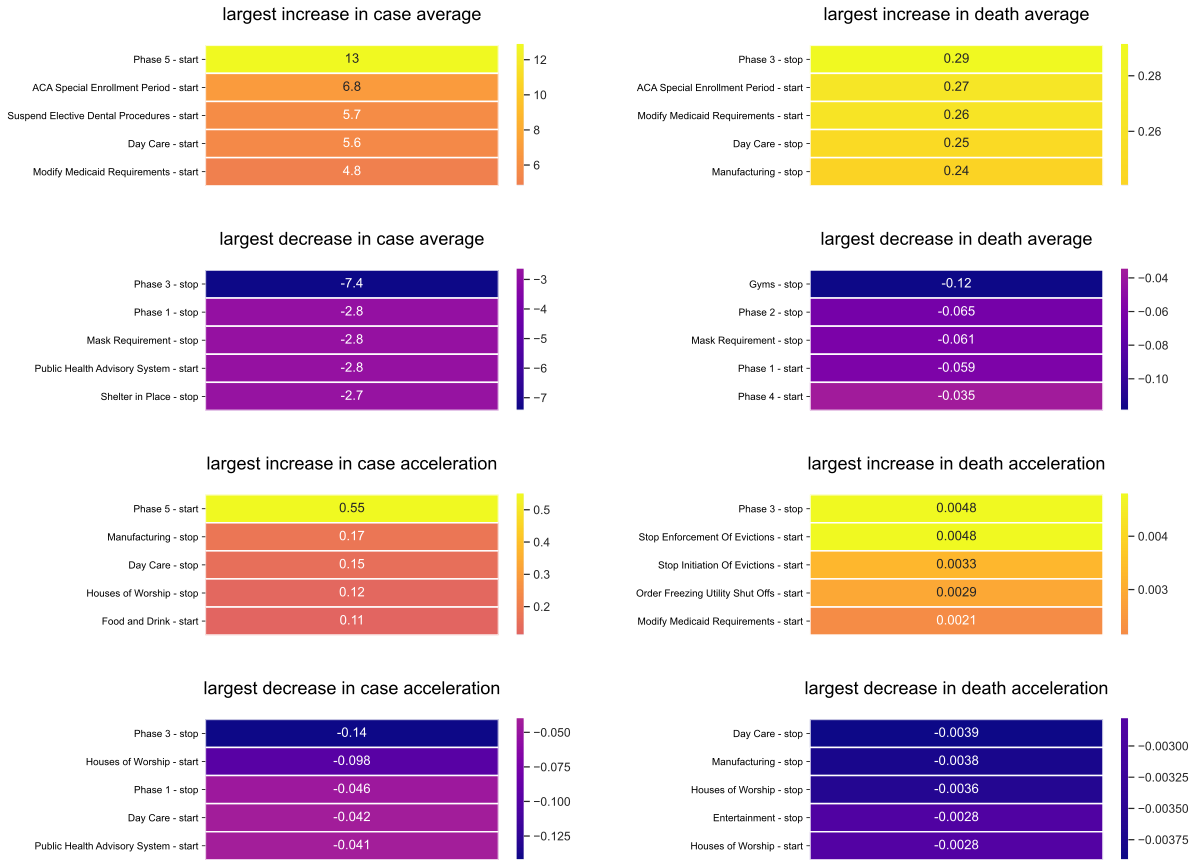

In [14]:
dfs_case = [deltas.sort_values(by="case_avg", ascending=False)[["case_avg"]].head(),
       deltas.sort_values(by="case_avg", ascending=True)["case_avg"].head(), 
       deltas.sort_values(by="case_accel_avg", ascending=False)["case_accel_avg"].head(),
       deltas.sort_values(by="case_accel_avg", ascending=True)["case_accel_avg"].head()]

dfs_death = [deltas.sort_values(by="death_avg", ascending=False)["death_avg"].head(),
       deltas.sort_values(by="death_avg", ascending=True)["death_avg"].head(), 
       deltas.sort_values(by="death_accel_avg", ascending=False)["death_accel_avg"].head(),
       deltas.sort_values(by="death_accel_avg", ascending=True)["death_accel_avg"].head()]


titles_case = [
    "largest increase in case average\n",
    "largest decrease in case average\n",
    "largest increase in case acceleration\n",
    "largest decrease in case acceleration\n", 
]

titles_death = [
    "largest increase in death average\n", 
    "largest decrease in death average\n", 
    "largest increase in death acceleration\n", 
    "largest decrease in death acceleration\n"
]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[15, 15])
plt.subplots_adjust(hspace=0.6, wspace=0.65, left=0)
sns.set(font_scale=1.1)

for i in range(len(ax[:,0])): 
        handles = sns.heatmap(np.asarray(dfs_case[i]).reshape(5,1), 
                              yticklabels=dfs_case[i].index, 
                              xticklabels="",
                              ax=ax[i,0], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma",
                              center = 0, 
                              linewidths=1.5
                             )
        ax[i,0].set_title(titles_case[i], fontsize=18)
        
        handles = sns.heatmap(np.asarray(dfs_death[i]).reshape(5,1), 
                              yticklabels=dfs_death[i].index,
                              xticklabels="", 
                              ax=ax[i,1], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma", 
                              center = 0,
                              linewidths=1.5
                             )
        ax[i,1].set_title(titles_death[i], fontsize=18)

In each heatmap, 4/5 of the policies are either all stop or all start. The results are summarized here: 

|              |           start              |            stop              |
| :----------: | :--------------------------: | :--------------------------: |
| **increase** | case avg, death acceleration | death avg, case acceleration | 
| **decrease** | death avg, case acceleration | case avg, death acceleration |


Looking back at the earlier predictions, this is exactly what we expected! starting a policy is correlated with an increase in average number of cases but decrease in acceleration, and vice versa for the start of a policy. 

What's even more interesting is that the death metrics. They appear to be the exact opposite of cases. I'll have to save an interpretation on this for later iterations of this project, as it might be wise to investigate these trends with several different time frames. 

It is imporant to remember that correlation =/= causation. Even though closing houses of worship is correlated with the largest decrease in case acceleration, that does not mean that closing houses of worship CAUSED the largest decrease in case acceleration. There are many, many variables involved. Some of them we can control- such as multiple policies being implemented within a short timespan, and specific details of a policy implementation\*; however, there are many others that we cannot control- such public compliance and advancments in treatment, which are out of the scope of this project. 

To control for the implementation of multiple policies, a linear regression algorithm might be able to help, as described in the next section. 

\*The COVID-19 policies dataset includes a field for comments which has more details of the implementation. This may be the subject of a future text-mining project to examine specific policies in a more granular fashion. 